In [1]:
import random
import numpy as np
import scipy
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import f
from scipy.stats import chi2
from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import mannwhitneyu
import docx
%matplotlib inline

In [2]:
def chi2_two_sample_test(X1, X2):
    n1 = sum(X1)
    n2 = sum(X2)
    k1 = np.sqrt(n1/n2)
    k2 = np.sqrt(n2/n1)
    z = 0.
    for i in range(len(X1)):
        z+=(k1*X2[i] - k2*X1[i])**2/(X2[i]+X1[i])
    if n1 != n2:
        p_val = 1 - stats.chi2(len(X1) - 1).cdf(z)
    else:
        p_val = 1 - stats.chi2(len(X1)).cdf(z)
    return (z, p_val)

In [3]:
'''
def chi2_two_sample_test(hist_1, hist_2):
    n1 = sum(hist_1[0])
    n2 = sum(hist_2[0])
    z = 0.
    for i in range(len(hist_1[0])):
        z+=(1./(hist_1[0][i] + hist_2[0][i]))*(hist_1[0][i]/n1 - hist_2[0][i]/n2)
    z*=n1*n2
    p_val = 1 - stats.chi2(len(hist_1[0]) - 1).cdf(z)
    return (z, p_val)
'''

'\ndef chi2_two_sample_test(hist_1, hist_2):\n    n1 = sum(hist_1[0])\n    n2 = sum(hist_2[0])\n    z = 0.\n    for i in range(len(hist_1[0])):\n        z+=(1./(hist_1[0][i] + hist_2[0][i]))*(hist_1[0][i]/n1 - hist_2[0][i]/n2)\n    z*=n1*n2\n    p_val = 1 - stats.chi2(len(hist_1[0]) - 1).cdf(z)\n    return (z, p_val)\n'

In [4]:
def emp_func_distr(X):
    emp_func = np.zeros((len(X),2))
    for i in range(len(X)):
        emp_func[i][0] = X[i]
        emp_func[i][1] = sum(X<X[i])
    emp_func[:,1] = emp_func[:,1]/len(X)
    emp_func = np.array(sorted(emp_func.tolist(), key = lambda x: x[0]))
    return emp_func

In [5]:
def count_hi_stat_chi5(hist, num_el):
    observed_frequences = hist[0] * (hist[1][1] - hist[1][0]) * num_el
    expected_frequences = stats.chi2.cdf(hist[1], df = 5)
    expected_frequences = [expected_frequences[i + 1] - expected_frequences[i] for i in range(len(hist[1]) - 1)]
    expected_frequences = np.array(expected_frequences) * num_el
    return stats.chisquare(observed_frequences, expected_frequences)

In [6]:
def count_hi_stat_norm(hist, num_el):
    observed_frequences = hist[0] * (hist[1][1] - hist[1][0]) * num_el
    expected_frequences = stats.norm.cdf(hist[1])
    expected_frequences = [expected_frequences[i + 1] - expected_frequences[i] for i in range(len(hist[1]) - 1)]
    expected_frequences = np.array(expected_frequences)*num_el
    return stats.chisquare(observed_frequences, expected_frequences, ddof = 2)

In [7]:
def count_hi_stat_R(hist, num_el):
    observed_frequences = hist[0] * (hist[1][1] - hist[1][0]) * num_el
    a = np.min(hist[1])
    b = np.max(hist[1])
    f = 1./(b-a)
    expected_frequences = [f*(hist[1][1] - hist[1][0])]*len(hist[0])
    expected_frequences = np.array(expected_frequences) * num_el
    return stats.chisquare(observed_frequences, expected_frequences)

In [8]:
class distr:
    def __init__(self, random_state, name, n, *args):
        self.name = name
        self.args = args
        self.n = n
        
        if name == 'norm':
            self.data = stats.norm.rvs(args[0], args[1], size = n, random_state = random_state)
            self.r_mean = args[0]
            self.r_var = args[1]**2
            self.r_std = args[1]
            
        if name == 'chi2':
            self.data = stats.chi2.rvs(args[0], size = n, random_state = random_state)
            self.r_mean = args[0]
            self.r_var = args[0]*2
            self.r_std = np.sqrt(args[0]*2)
            
        if name == 'r':
            self.data = stats.uniform(loc = args[0], scale = args[1] - args[0]).rvs(size = n, random_state = random_state)
            self.r_mean = (args[0] + args[1])/2.
            self.r_var = (args[1] - args[0])**2/12.
            self.r_std = np.sqrt((args[1] - args[0])**2/12.)
            
        self.s_mean = self.data.mean()
        self.s_var = self.data.var()
        self.s_std = self.data.std()
        
        
    def __str__(self):
        return str(self.name) + ' ' + str(self.args) + ' ' + str(self.n) + \
                ' sample_mean=' + str(round(self.s_mean, 2)) + ' sample_var=' + str(round(self.s_var, 2))
    
    def z_test(self, m0):
        z = (self.s_mean - m0)/(self.r_std/np.sqrt(self.n))
        p_val = 2*(1 - stats.norm.cdf(abs(z)))
        return (z, p_val)
    
    def t_test(self, m0):
        z = (self.s_mean - m0)/(self.s_std/np.sqrt(self.n))
        p_val = 2*(1 - stats.t.cdf(abs(z), self.n - 1))
        return (z, p_val)
    
    def chi2_test0(self, v0):
        z = np.sum((self.data - self.r_mean)**2)/v0
        p_val = 2*min(1 - stats.chi2.cdf(z, self.n), stats.chi2.cdf(z, self.n))
        return (z, p_val)
    
    def chi2_test1(self, v0):
        z = self.s_var*(self.n - 1)/v0
        p_val = 2*min(1 - stats.chi2.cdf(z, self.n - 1), stats.chi2.cdf(z, self.n - 1))
        return (z, p_val)

In [9]:
def pooled_mean(*args):
    res = sum([len(args[i])*np.mean(args[i]) for i in range(len(args))])/sum([len(args[i]) for i in range(len(args))])
    return res
def pooled_var(*args):
    res = sum([(len(args[i])-1)*np.var(args[i]) for i in range(len(args))])/sum([(len(args[i])-1) for i in range(len(args))])
    return res

In [10]:
def task_1(dist_1:distr, dist_2:distr, doc):
    
    doc.tables[0].rows[1].cells[0].text  = dist_1.name 
    
    if dist_1.name == 'norm':
        doc.tables[0].rows[1].cells[1].text  = 'm='+str(dist_1.args[0])+'\nstd='+str(dist_1.args[1])
        doc.tables[0].rows[1].cells[2].text  = str(dist_1.args[0])
        doc.tables[0].rows[1].cells[3].text  = str(round(dist_1.args[1]**2))
        
    if dist_1.name == 'chi2':
        doc.tables[0].rows[1].cells[1].text  = 'число ст. своб='+str(dist_1.args[0])
        doc.tables[0].rows[1].cells[2].text  = str(dist_1.args[0])
        doc.tables[0].rows[1].cells[3].text  = str(round(dist_1.args[0]*2))
        
    if dist_1.name == 'r':
        doc.tables[0].rows[1].cells[1].text  = 'a='+str(dist_1.args[0])+'\nb='+str(dist_1.args[1])
        doc.tables[0].rows[1].cells[2].text  = str(round((dist_1.args[0] + dist_1.args[1])/2., 2))
        doc.tables[0].rows[1].cells[3].text  = str(round((dist_1.args[1] - dist_1.args[0])**2/12., 2))
         
   
   
    doc.tables[1].rows[1].cells[0].text = str(round(dist_1.s_mean, 2))
    doc.tables[1].rows[1].cells[1].text = str(round(dist_1.s_var, 2))
    doc.tables[1].rows[1].cells[2].text = str(round(dist_1.s_var**(0.5), 2))
    
    doc.tables[6].rows[1].cells[0].text  = dist_2.name 
    
    if dist_2.name == 'norm':
        doc.tables[6].rows[1].cells[1].text  = 'm='+str(dist_2.args[0])+'\nstd='+str(dist_2.args[1])
        doc.tables[6].rows[1].cells[2].text  = str(dist_2.args[0])
        doc.tables[6].rows[1].cells[3].text  = str(round(dist_2.args[1]**2))
        
    if dist_2.name == 'chi2':
        doc.tables[6].rows[1].cells[1].text  = 'число ст. своб='+str(dist_2.args[0])
        doc.tables[6].rows[1].cells[2].text  = str(dist_2.args[0])
        doc.tables[6].rows[1].cells[3].text  = str(round(dist_2.args[0]*2))
        
    if dist_2.name == 'r':
        doc.tables[6].rows[1].cells[1].text  = 'a='+str(dist_2.args[0])+'\nb='+str(dist_2.args[1])
        doc.tables[6].rows[1].cells[2].text  = str(round((dist_2.args[0] + dist_2.args[1])/2., 2))
        doc.tables[6].rows[1].cells[3].text  = str(round((dist_2.args[1] - dist_2.args[0])**2/12., 2))
        
    

In [12]:
def task_2(dist_1:distr, alpha, doc):
    
    X1_1 = ((dist_1.data - dist_1.s_mean)/dist_1.s_std)
    hist_1 = plt.hist(X1_1, bins = 5, density= True)
    hist_2 = plt.hist(X1_1, bins = 10, density= True)
    hist_3 = plt.hist(X1_1, bins = 15, density= True)
    hist_4 = plt.hist(X1_1, bins = 25, density= True)
    
    z1 = count_hi_stat_norm(hist_1, dist_1.n)
    z2 = count_hi_stat_norm(hist_2, dist_1.n)
    z3 = count_hi_stat_norm(hist_3, dist_1.n)
    z4 = count_hi_stat_norm(hist_4, dist_1.n)
    
    doc.tables[2].rows[1].cells[1].text = str(round(z1[0], 3))
    doc.tables[2].rows[2].cells[1].text = str(round(z2[0], 3))
    doc.tables[2].rows[3].cells[1].text = str(round(z3[0], 3))
    doc.tables[2].rows[4].cells[1].text = str(round(z4[0], 3))
    
    doc.tables[2].rows[1].cells[2].text = "{:.3e}".format(z1[1])
    doc.tables[2].rows[2].cells[2].text = "{:.3e}".format(z2[1])
    doc.tables[2].rows[3].cells[2].text = "{:.3e}".format(z3[1])
    doc.tables[2].rows[4].cells[2].text = "{:.3e}".format(z4[1])
    
    p_arr = [z1[1], z2[1], z3[1], z4[1]]
    
    for val in enumerate(p_arr):
        
        if val[1] < alpha:
            
            doc.tables[2].rows[val[0] + 1].cells[3].text = 'H0 отверг'
            if dist_1.name == 'norm':
                doc.tables[2].rows[val[0] + 1].cells[4].text = 'Ош. 1го рода'
            else:
                doc.tables[2].rows[val[0] + 1].cells[4].text = 'Нет ош.'
                
        else:
            
            doc.tables[2].rows[val[0] + 1].cells[3].text = 'H0 приним'
            
            if dist_1.name == 'norm':
                doc.tables[2].rows[val[0] + 1].cells[4].text = 'Нет ош.'
            else:
                doc.tables[2].rows[val[0] + 1].cells[4].text = 'Ош. 2го рода'
                
    hist_1 = plt.hist(dist_1.data, bins = 5, density = True)
    hist_2 = plt.hist(dist_1.data, bins = 10, density = True)
    hist_3 = plt.hist(dist_1.data, bins = 15, density = True)
    hist_4 = plt.hist(dist_1.data, bins = 25, density = True)
                
    z1 = count_hi_stat_R(hist_1, dist_1.n)
    z2 = count_hi_stat_R(hist_2, dist_1.n)
    z3 = count_hi_stat_R(hist_3, dist_1.n)
    z4 = count_hi_stat_R(hist_4, dist_1.n)
    
    doc.tables[3].rows[1].cells[1].text = str(round(z1[0], 3))
    doc.tables[3].rows[2].cells[1].text = str(round(z2[0], 3))
    doc.tables[3].rows[3].cells[1].text = str(round(z3[0], 3))
    doc.tables[3].rows[4].cells[1].text = str(round(z4[0], 3))
    
    doc.tables[3].rows[1].cells[2].text = "{:.3e}".format(z1[1])
    doc.tables[3].rows[2].cells[2].text = "{:.3e}".format(z2[1])
    doc.tables[3].rows[3].cells[2].text = "{:.3e}".format(z3[1])
    doc.tables[3].rows[4].cells[2].text = "{:.3e}".format(z4[1])
    
    p_arr = [z1[1], z2[1], z3[1], z4[1]]
    
    for val in enumerate(p_arr):
        
        if val[1] < alpha:
            
            doc.tables[3].rows[val[0] + 1].cells[3].text = 'H0 отверг'
            if dist_1.name == 'r':
                doc.tables[3].rows[val[0] + 1].cells[4].text = 'Ош. 1го рода'
            else:
                doc.tables[3].rows[val[0] + 1].cells[4].text = 'Нет ош.'
                
        else:
            
            doc.tables[3].rows[val[0] + 1].cells[3].text = 'H0 приним'
            
            if dist_1.name == 'r':
                doc.tables[3].rows[val[0] + 1].cells[4].text = 'Нет ош.'
            else:
                doc.tables[3].rows[val[0] + 1].cells[4].text = 'Ош. 2го рода'
                
    z1 = count_hi_stat_chi5(hist_1, dist_1.n)
    z2 = count_hi_stat_chi5(hist_2, dist_1.n)
    z3 = count_hi_stat_chi5(hist_3, dist_1.n)
    z4 = count_hi_stat_chi5(hist_4, dist_1.n)
    
    doc.tables[4].rows[1].cells[1].text = str(round(z1[0], 3))
    doc.tables[4].rows[2].cells[1].text = str(round(z2[0], 3))
    doc.tables[4].rows[3].cells[1].text = str(round(z3[0], 3))
    doc.tables[4].rows[4].cells[1].text = str(round(z4[0], 3))
    
    doc.tables[4].rows[1].cells[2].text = "{:.3e}".format(z1[1])
    doc.tables[4].rows[2].cells[2].text = "{:.3e}".format(z2[1])
    doc.tables[4].rows[3].cells[2].text = "{:.3e}".format(z3[1])
    doc.tables[4].rows[4].cells[2].text = "{:.3e}".format(z4[1])
    
    p_arr = [z1[1], z2[1], z3[1], z4[1]]
    
    for val in enumerate(p_arr):
        
        if val[1] < alpha:
            
            doc.tables[4].rows[val[0] + 1].cells[3].text = 'H0 отверг'
            if dist_1.name == 'chi2' and dist_1.args[0] == 5:
                doc.tables[4].rows[val[0] + 1].cells[4].text = 'Ош. 1го рода'
            else:
                doc.tables[4].rows[val[0] + 1].cells[4].text = 'Нет ош.'
                
        else:
            
            doc.tables[4].rows[val[0] + 1].cells[3].text = 'H0 приним'
            
            if dist_1.name == 'chi2' and dist_1.args[0] == 5:
                doc.tables[4].rows[val[0] + 1].cells[4].text = 'Нет ош.'
            else:
                doc.tables[4].rows[val[0] + 1].cells[4].text = 'Ош. 2го рода'
                
    z1 = stats.kstest(dist_1.data, 'norm', args = (dist_1.r_mean, dist_1.r_std))
    z2 = stats.kstest(dist_1.data, lambda x: (x - min(dist_1.data))/(max(dist_1.data)-min(dist_1.data)))
    z3 = stats.kstest(dist_1.data, 'chi2', args = (5,))
    
    doc.tables[5].rows[1].cells[1].text = str(round(z1[0], 3))
    doc.tables[5].rows[2].cells[1].text = str(round(z2[0], 3))
    doc.tables[5].rows[3].cells[1].text = str(round(z3[0], 3))
    
    doc.tables[5].rows[1].cells[2].text = "{:.3e}".format(z1[1])
    doc.tables[5].rows[2].cells[2].text = "{:.3e}".format(z2[1])
    doc.tables[5].rows[3].cells[2].text = "{:.3e}".format(z3[1])
    
    if z1[1] < alpha:
            
        doc.tables[5].rows[1].cells[3].text = 'H0 отверг'
        if dist_1.name == 'norm':
            doc.tables[5].rows[1].cells[4].text = 'Ош. 1го рода'
        else:
            doc.tables[5].rows[1].cells[4].text = 'Нет ош.'
                
    else:
        doc.tables[5].rows[1].cells[3].text = 'H0 приним'
            
        if dist_1.name == 'norm':
            doc.tables[5].rows[1].cells[4].text = 'Нет ош.'
        else:
            doc.tables[5].rows[1].cells[4].text = 'Ош. 2го рода'
            
    if z2[1] < alpha:
            
        doc.tables[5].rows[2].cells[3].text = 'H0 отверг'
        if dist_1.name == 'r':
            doc.tables[5].rows[2].cells[4].text = 'Ош. 1го рода'
        else:
            doc.tables[5].rows[2].cells[4].text = 'Нет ош.'
                
    else:
        doc.tables[5].rows[2].cells[3].text = 'H0 приним'
            
        if dist_1.name == 'r':
            doc.tables[5].rows[2].cells[4].text = 'Нет ош.'
        else:
            doc.tables[5].rows[2].cells[4].text = 'Ош. 2го рода'
            
    if z3[1] < alpha:
            
        doc.tables[5].rows[3].cells[3].text = 'H0 отверг'
        if dist_1.name == 'chi2' and dist_1.args[0] == 5:
            doc.tables[5].rows[3].cells[4].text = 'Ош. 1го рода'
        else:
            doc.tables[5].rows[3].cells[4].text = 'Нет ош.'
                
    else:
        doc.tables[5].rows[3].cells[3].text = 'H0 приним'
            
        if dist_1.name == 'chi2' and dist_1.args[0] == 5:
            doc.tables[5].rows[3].cells[4].text = 'Нет ош.'
        else:
            doc.tables[5].rows[3].cells[4].text = 'Ош. 2го рода'
        
        

In [13]:
def graphics(dist_1, dist_2):
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(15.5, 10.5)
    ax[0][0].hist(dist_1.data, bins = 5, density= True)
    ax[0][0].set_xlabel('nBins = 5')
    ax[0][1].hist(dist_1.data, bins = 10, density= True)
    ax[0][1].set_xlabel('nBins = 10')
    ax[1][0].hist(dist_1.data, bins = 15, density= True)
    ax[1][0].set_xlabel('nBins = 15')
    ax[1][1].hist(dist_1.data, bins = 25, density= True)
    ax[1][1].set_xlabel('nBins = 25')
    plt.savefig('lab2_im/lab2_hist.png')
    
    emp_func = emp_func_distr(dist_1.data)
    fig, ax = plt.subplots(1, 1)
    ax.plot(emp_func[:,0], emp_func[:,1],
          'r-', lw=2, alpha=0.6, label='emp_func')
    x = np.linspace(min(emp_func[:,0]), max(emp_func[:,0]), 100)
    ax.plot(x, stats.norm(dist_1.r_mean, dist_1.r_std).cdf(x), linestyle='dashed', linewidth = 2, label = 'norm')
    ax.plot(x, stats.chi2(5).cdf(x), linestyle=':', linewidth = 2, label = 'chi2')
    ax.plot(x, stats.uniform(min(dist_1.data),max(dist_1.data)-min(dist_1.data)).cdf(x), linestyle='-.', linewidth = 2, label = 'uniform')
    ax.set_xlabel('x')
    ax.set_ylabel('cdf(x)')
    ax.legend(loc='best', frameon=False)
    plt.savefig('lab2_im/lab2_1.png')
    
    fig, ax = plt.subplots(1, 1)
    x_left = max(min(dist_1.data), min(dist_2.data))
    x_right = min(max(dist_1.data), max(dist_2.data))
    hist_1 = ax.hist(dist_1.data, bins = 15, density = True, label = 'X', range = (x_left, x_right))
    hist_2 = ax.hist(dist_2.data, bins = 15, density = True, histtype = 'step', label = 'Y', range = (x_left, x_right))
    ax.legend(loc='best', frameon=False)
    plt.savefig('lab2_im/hist_X_Y.png')
    
    fig, ax = plt.subplots(1, 1)
    emp_func_1 = emp_func_distr(dist_1.data)
    emp_func_2 = emp_func_distr(dist_2.data)
    ax.plot(emp_func_1[:,0], emp_func_1[:,1], label = 'X')
    ax.plot(emp_func_2[:,0], emp_func_2[:,1], label = 'Y')
    ax.legend(loc='best', frameon=False)
    plt.savefig('lab2_im/ECDF_X_Y.png')
    

In [14]:
def task_3(dist_1:distr, dist_2:distr, alpha, doc):
    
    fig, ax = plt.subplots(1, 1)
    
    x_left = max(min(dist_1.data), min(dist_2.data))
    x_right = min(max(dist_1.data), max(dist_2.data))
    hist_1 = ax.hist(dist_1.data, bins = 15, density = False, label = 'X', range = (x_left, x_right))
    hist_2 = ax.hist(dist_2.data, bins = 15, density = False, histtype = 'step', label = 'Y', range = (x_left, x_right))
    
    z1 = chi2_two_sample_test(hist_1[0], hist_2[0])
    z2 = stats.ks_2samp(dist_1.data, dist_2.data)
    if dist_1.n == dist_2.n:
        z3 = sign_test(np.array(sorted(dist_1.data))-np.array(sorted(dist_2.data)))
    else:
        size = min(dist_1.n, dist_2.n)
        z3 = sign_test(np.array(sorted(dist_1.data[:size]))-np.array(sorted(dist_2.data[:size])))
    z4 = mannwhitneyu(dist_1.data, dist_2.data)
    
    doc.tables[7].rows[1].cells[2].text = str(round(z1[0], 3))
    doc.tables[7].rows[2].cells[2].text = str(round(z2[0], 3))
    doc.tables[7].rows[3].cells[2].text = str(round(z3[0], 3))
    doc.tables[7].rows[4].cells[2].text = str(round(z4[0], 3))
    
    doc.tables[7].rows[1].cells[3].text = "{:.3e}".format(z1[1])
    doc.tables[7].rows[2].cells[3].text = "{:.3e}".format(z2[1])
    doc.tables[7].rows[3].cells[3].text = "{:.3e}".format(z3[1])
    doc.tables[7].rows[4].cells[3].text = "{:.3e}".format(z4[1])
    
    p_arr = [z1[1], z2[1], z3[1], z4[1]]
    
    for val in enumerate(p_arr):
        
        if val[1] < alpha:
            
            doc.tables[7].rows[val[0] + 1].cells[4].text = 'H0 отверг'
            if dist_1.name == dist_2.name and dist_1.args == dist_2.args:
                doc.tables[7].rows[val[0] + 1].cells[5].text = 'Ош. 1го рода'
            else:
                doc.tables[7].rows[val[0] + 1].cells[5].text = 'Нет ош.'
                
        else:
            
            doc.tables[7].rows[val[0] + 1].cells[4].text = 'H0 приним'
            
            if dist_1.name == dist_2.name and dist_1.args == dist_2.args:
                doc.tables[7].rows[val[0] + 1].cells[5].text = 'Нет ош.'
            else:
                doc.tables[7].rows[val[0] + 1].cells[5].text = 'Ош. 2го рода'

In [15]:
doc = docx.Document('ms_otchet2.docx')
d_1 = distr(712, 'r', 50, 2, 6)
d_2 = distr(713, 'r', 50, 2, 6)
print(d_1, d_2, sep = '\n')

r (2, 6) 50 sample_mean=3.8 sample_var=1.35
r (2, 6) 50 sample_mean=4.16 sample_var=1.51


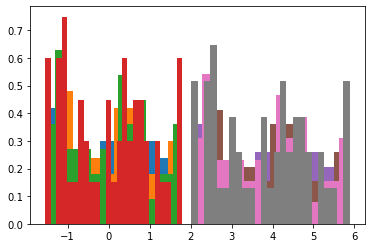

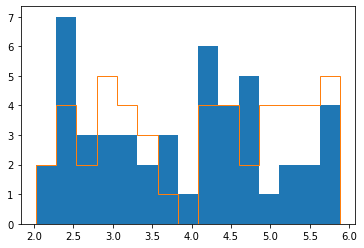

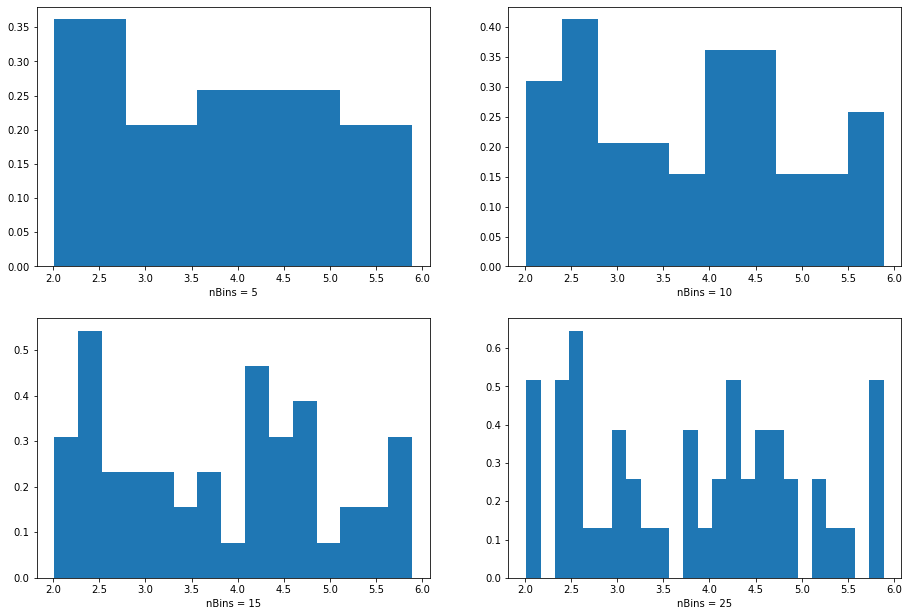

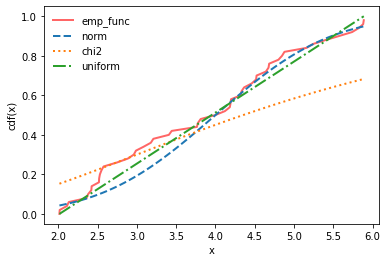

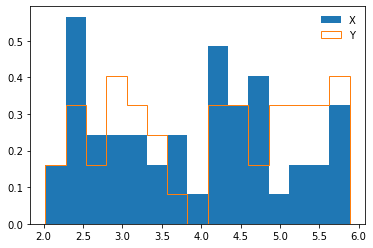

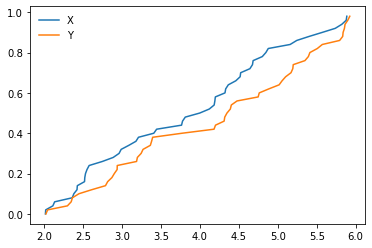

In [16]:
task_1(d_1, d_2, doc)
task_2(d_1, 0.05, doc)
task_3(d_1, d_2, 0.05, doc)
graphics(d_1, d_2)
doc.save('lab2_nik.docx')